In [1]:
# general tools
import os
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras_unet_collection import utils as k_utils

2022-12-27 14:13:32.576870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def pos_mixer(TRAIN, L, a0=0, a1=0.2):
    data_shape = TRAIN.shape
    out = np.empty((L, data_shape[-1]))
    
    for i in range(L):
        inds = np.random.choice(data_shape[0], 2)
        a = np.random.uniform(a0, a1)
        out[i, :] = a*TRAIN[inds[0], :] + (1-a)*TRAIN[inds[1], :]
    return out

In [7]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [8]:
def verif_metric(VALID_target, Y_pred, ref):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    #print('{}'.format(BS))
    metric = BS

    return metric / ref

In [9]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [10]:
def feature_extract(filenames, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max):
    
    lon_out = []
    lat_out = []
    elev_out = []
    mon_out = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180-151)]
    
    for i, name in enumerate(filenames):
        
        if 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
        day = date_list[day]
        month = day.month
        
        month_norm = (month - 1)/(12-1)
        
        lon = lon_80km[indx, indy]
        lat = lat_80km[indx, indy]

        lon = (lon - lon_minmax[0])/(lon_minmax[1] - lon_minmax[0])
        lat = (lat - lat_minmax[0])/(lat_minmax[1] - lat_minmax[0])

        elev = elev_80km[indx, indy]
        elev = elev / elev_max
        
        lon_out.append(lon)
        lat_out.append(lat)
        elev_out.append(elev)
        mon_out.append(month_norm)
        
    return np.array(lon_out), np.array(lat_out), np.array(elev_out), np.array(mon_out)

def create_model():

    
    IN_vec = keras.Input((512,))    
    IN_elev = keras.Input((123,))
    IN = keras.layers.Concatenate()([IN_vec, IN_elev])
    
    X = IN
    #
    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)

    X = keras.layers.Dropout(0.4)(X)
    
    #
    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    
    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=[IN_vec, IN_elev], outputs=OUT)
    
    return model

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    
grid_shape = land_mask_80km.shape

In [12]:
elev_80km = du.interp2d_wraper(lon_3km, lat_3km, elev_3km, lon_80km, lat_80km, method='linear')

elev_80km[np.isnan(elev_80km)] = 0
elev_80km[elev_80km<0] = 0
elev_max = np.max(elev_80km)

lon_80km_mask = lon_80km[land_mask_80km]
lat_80km_mask = lat_80km[land_mask_80km]

lon_minmax = [np.min(lon_80km_mask), np.max(lon_80km_mask)]
lat_minmax = [np.min(lat_80km_mask), np.max(lat_80km_mask)]

In [13]:
lead = 4

In [14]:
filepath_train = "/glade/scratch/ksha/DATA/NCAR_batch/"
filepath_valid = "/glade/scratch/ksha/DATA/NCAR_batch/"
filepath_test = "/glade/scratch/ksha/DATA/NCAR_batch_v4/"
filepath_vec = "/glade/work/ksha/NCAR/"

In [15]:
filename_train_lead2 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead2.npy"))
filename_train_lead3 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead3.npy"))
filename_train_lead4 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead4.npy"))
filename_train_lead5 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead5.npy"))
filename_train_lead6 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*lead6.npy"))

In [16]:
filename_train = filename_train_lead2 + filename_train_lead3 + filename_train_lead4 + filename_train_lead5 + filename_train_lead6

In [17]:
IND_TRAIN_lead = np.load('/glade/work/ksha/NCAR/IND_TRAIN_lead.npy', allow_pickle=True)[()]
TRAIN_ind2 = IND_TRAIN_lead['lead2']
TRAIN_ind3 = IND_TRAIN_lead['lead3']
TRAIN_ind4 = IND_TRAIN_lead['lead4']

In [18]:
TRAIN_ind5 = IND_TRAIN_lead['lead5']

In [19]:
data_lead2_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 2), allow_pickle=True)[()]
data_lead2_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 2), allow_pickle=True)[()]
data_lead2_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 2), allow_pickle=True)[()]

data_lead3_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 3), allow_pickle=True)[()]
data_lead3_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 3), allow_pickle=True)[()]
data_lead3_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 3), allow_pickle=True)[()]

data_lead4_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 4), allow_pickle=True)[()]
data_lead4_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 4), allow_pickle=True)[()]
data_lead4_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 4), allow_pickle=True)[()]

data_lead5_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 5), allow_pickle=True)[()]
data_lead5_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 5), allow_pickle=True)[()]
data_lead5_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 5), allow_pickle=True)[()]

data_lead6_p0 = np.load('{}TRAIN_pp15_pred_lead{}_part0_base.npy'.format(filepath_vec, 6), allow_pickle=True)[()]
data_lead6_p1 = np.load('{}TRAIN_pp15_pred_lead{}_part1_base.npy'.format(filepath_vec, 6), allow_pickle=True)[()]
data_lead6_p2 = np.load('{}TRAIN_pp15_pred_lead{}_part2_base.npy'.format(filepath_vec, 6), allow_pickle=True)[()]

In [20]:
TRAIN_lead2 = np.concatenate((data_lead2_p0['y_vector'], data_lead2_p1['y_vector'], data_lead2_p2['y_vector']), axis=0)
TRAIN_lead3 = np.concatenate((data_lead3_p0['y_vector'], data_lead3_p1['y_vector'], data_lead3_p2['y_vector']), axis=0)
TRAIN_lead4 = np.concatenate((data_lead4_p0['y_vector'], data_lead4_p1['y_vector'], data_lead4_p2['y_vector']), axis=0)
TRAIN_lead5 = np.concatenate((data_lead5_p0['y_vector'], data_lead5_p1['y_vector'], data_lead5_p2['y_vector']), axis=0)
TRAIN_lead6 = np.concatenate((data_lead6_p0['y_vector'], data_lead6_p1['y_vector'], data_lead6_p2['y_vector']), axis=0)

In [21]:
TRAIN_lead2_y = np.concatenate((data_lead2_p0['y_true'], data_lead2_p1['y_true'], data_lead2_p2['y_true']), axis=0)
TRAIN_lead3_y = np.concatenate((data_lead3_p0['y_true'], data_lead3_p1['y_true'], data_lead3_p2['y_true']), axis=0)
TRAIN_lead4_y = np.concatenate((data_lead4_p0['y_true'], data_lead4_p1['y_true'], data_lead4_p2['y_true']), axis=0)
TRAIN_lead5_y = np.concatenate((data_lead5_p0['y_true'], data_lead5_p1['y_true'], data_lead5_p2['y_true']), axis=0)
TRAIN_lead6_y = np.concatenate((data_lead6_p0['y_true'], data_lead6_p1['y_true'], data_lead6_p2['y_true']), axis=0)

In [22]:
L = len(TRAIN_ind4)
filename_train2_pick = []
filename_train3_pick = []
filename_train4_pick = []
filename_train5_pick = []

TRAIN_X = np.empty((L, 512))
TRAIN_Y = np.empty(L)

for i in range(L):
    ind_lead2 = int(TRAIN_ind2[i])
    ind_lead3 = int(TRAIN_ind3[i])
    ind_lead4 = int(TRAIN_ind4[i])
    ind_lead5 = int(TRAIN_ind5[i])
    
    filename_train2_pick.append(filename_train_lead2[ind_lead2])
    filename_train3_pick.append(filename_train_lead3[ind_lead3])
    filename_train4_pick.append(filename_train_lead4[ind_lead4])
    filename_train5_pick.append(filename_train_lead5[ind_lead5])
    
    TRAIN_X[i, 0:128]   = TRAIN_lead2[ind_lead2, :]
    TRAIN_X[i, 128:256] = TRAIN_lead3[ind_lead3, :]
    TRAIN_X[i, 256:384] = TRAIN_lead4[ind_lead4, :]
    TRAIN_X[i, 384:512] = TRAIN_lead5[ind_lead5, :]
    
    TRAIN_Y[i] = TRAIN_lead4_y[ind_lead4]

In [23]:
#np.sum(TRAIN_lead2_y) / len(TRAIN_lead2_y)

In [24]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_train4_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [25]:
data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(2), allow_pickle=True)[()]
MEAN_lead2 = data_temp['MEAN']
MAX_lead2 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(3), allow_pickle=True)[()]
MEAN_lead3 = data_temp['MEAN']
MAX_lead3 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(4), allow_pickle=True)[()]
MEAN_lead4 = data_temp['MEAN']
MAX_lead4 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/TRAIN_MINMAX_lead{}.npy'.format(5), allow_pickle=True)[()]
MEAN_lead5 = data_temp['MEAN']
MAX_lead5 = data_temp['MAX']

In [26]:
TRAIN_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None], 
                            MAX_lead2, MAX_lead3, MAX_lead4, MAX_lead5, 
                            MEAN_lead2, MEAN_lead3, MEAN_lead4, MEAN_lead5), axis=1)
TRAIN_merge = TRAIN_stn

In [27]:
TRAIN_256_pos = TRAIN_X[TRAIN_Y==1, :]
TRAIN_256_neg = TRAIN_X[TRAIN_Y==0, :]

In [28]:
TRAIN_stn_pos = TRAIN_merge[TRAIN_Y==1]
TRAIN_stn_neg = TRAIN_merge[TRAIN_Y==0]

**Valid**

In [29]:
filename_valid_lead2 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead2.npy"))
filename_valid_lead3 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead3.npy"))
filename_valid_lead4 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead4.npy"))
filename_valid_lead5 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead5.npy"))
filename_valid_lead6 = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*lead6.npy"))

In [30]:
valid_lead2 = np.load('{}TEST_pp15_pred_lead2_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead3 = np.load('{}TEST_pp15_pred_lead3_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead4 = np.load('{}TEST_pp15_pred_lead4_base.npy'.format(filepath_vec), allow_pickle=True)[()]
valid_lead5 = np.load('{}TEST_pp15_pred_lead5_base.npy'.format(filepath_vec), allow_pickle=True)[()]

VALID_lead2 = valid_lead2['y_vector']
VALID_lead3 = valid_lead3['y_vector']
VALID_lead4 = valid_lead4['y_vector']
VALID_lead5 = valid_lead5['y_vector']

VALID_lead2_y = valid_lead2['y_true']
VALID_lead3_y = valid_lead3['y_true']
VALID_lead4_y = valid_lead4['y_true']
VALID_lead5_y = valid_lead5['y_true']

In [31]:
data_p_valid = np.load('{}TEST_pp15_pred_lead{}_base.npy'.format(filepath_vec, lead), allow_pickle=True)[()]

VALID_256 = data_p_valid['y_vector']
VALID_pred = data_p_valid['y_pred']
VALID_Y = data_p_valid['y_true']

In [32]:
IND_VALID_lead = np.load('/glade/work/ksha/NCAR/IND_VALID_lead.npy', allow_pickle=True)[()]
VALID_ind2 = IND_VALID_lead['lead2']
VALID_ind3 = IND_VALID_lead['lead3']
VALID_ind4 = IND_VALID_lead['lead4']
VALID_ind5 = IND_VALID_lead['lead5']

In [34]:
L = len(VALID_ind3)
filename_valid2_pick = []
filename_valid3_pick = []
filename_valid4_pick = []
filename_valid5_pick = []

VALID_X = np.empty((L, 512))
VALID_Y = np.zeros(L)

for i in range(L):
    ind_lead2 = int(VALID_ind2[i])
    ind_lead3 = int(VALID_ind3[i])
    ind_lead4 = int(VALID_ind4[i])
    ind_lead5 = int(VALID_ind5[i])
    
    filename_valid2_pick.append(filename_valid_lead2[ind_lead2])
    filename_valid3_pick.append(filename_valid_lead3[ind_lead3])
    filename_valid4_pick.append(filename_valid_lead4[ind_lead4])
    filename_valid5_pick.append(filename_valid_lead5[ind_lead5])
    
    VALID_X[i, 0:128]   = VALID_lead2[ind_lead2, :]
    VALID_X[i, 128:256] = VALID_lead3[ind_lead3, :]
    VALID_X[i, 256:384] = VALID_lead4[ind_lead4, :]
    VALID_X[i, 384:512] = VALID_lead5[ind_lead5, :]
    
    if 'pos' in filename_valid_lead4[ind_lead4]:
        if VALID_lead4_y[ind_lead4] == 1.0:
            VALID_Y[i] = 1.0
        else:
            egwrshat
        

In [35]:
lon_norm, lat_norm, elev_norm, mon_norm = feature_extract(
    filename_valid4_pick, lon_80km, lon_minmax, lat_80km, lat_minmax, elev_80km, elev_max)

In [36]:
data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(2), allow_pickle=True)[()]
MEAN_lead2 = data_temp['MEAN']
MAX_lead2 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(3), allow_pickle=True)[()]
MEAN_lead3 = data_temp['MEAN']
MAX_lead3 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(4), allow_pickle=True)[()]
MEAN_lead4 = data_temp['MEAN']
MAX_lead4 = data_temp['MAX']

data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(5), allow_pickle=True)[()]
MEAN_lead5 = data_temp['MEAN']
MAX_lead5 = data_temp['MAX']

# data_temp = np.load('/glade/work/ksha/NCAR/VALID_MINMAX_lead{}.npy'.format(6), allow_pickle=True)[()]
# MEAN_lead6 = data_temp['MEAN']
# MAX_lead6 = data_temp['MAX']

In [37]:
VALID_stn = np.concatenate((lon_norm[:, None], lat_norm[:, None], elev_norm[:, None], 
                            MAX_lead2, MAX_lead3, MAX_lead4, MAX_lead5, 
                            MEAN_lead2, MEAN_lead3, MEAN_lead4, MEAN_lead5), axis=1)
VALID_merge = VALID_stn

In [38]:
VALID_merge.shape

(278588, 123)

In [39]:
# initial_learning_rate = 1e-3

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,
#     decay_rate=0.96,
#     staircase=True)

# weight_for_0 = (1 / np.sum(TRAIN_Y==0)) * (len(TRAIN_Y) / 2.0)
# weight_for_1 = (1 / np.sum(TRAIN_Y==1)) * (len(TRAIN_Y) / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}

# model = create_model()

# model.compile(loss=keras.losses.mean_squared_error,
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#               metrics=keras.losses.mean_squared_error)

# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=100),
#              keras.callbacks.ModelCheckpoint(filepath=save_dir+'calib_model', 
#                                              monitor='val_loss', save_best_only=True)]

# model.fit(x=[TRAIN_X, TRAIN_merge], y=TRAIN_Y, batch_size=1000, epochs=1000, verbose=1,
#           callbacks=callbacks, validation_data=([VALID_X, VALID_merge], VALID_Y), shuffle=True)

In [40]:
# def decayed_learning_rate(step, initial_learning_rate=7.5e-4, decay_steps=50, alpha=1e-4):
#     step = np.min([step, decay_steps])
#     cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
#     decayed = (1 - alpha) * cosine_decay + alpha
#     return initial_learning_rate * decayed

In [41]:
training_rounds = 20
seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]

In [42]:
ref = np.sum(VALID_Y) / len(VALID_Y)

# =========== Model Section ========== #

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'MIX_Lead{}'.format(lead)

model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(TRAIN_256_pos)
L_neg = len(TRAIN_256_neg)

record = 1.1 #0.8545884976606543 #0.860262977437387 #0.867447696352988 #1.1
print("Initial record: {}".format(record))

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 64
L_train = 16 #int(len(TRAIN_Y_pick) / batch_size)

for r in range(training_rounds):
    if r == 0:
        tol = 0
    else:
        tol = -200

    model = create_model()
    #
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(lr=1e-4))
    
    # W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/BASE_Lead2/')
    # model.set_weights(W_old)
    
    set_seeds(int(seeds[r]))
    print('Training round {}'.format(r))

    for i in range(epochs):
        # if i > 0:
        #     backend.set_value(model.optimizer.learning_rate, decayed_learning_rate(i))
            
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            N_pos = 32
            N_neg = batch_size - N_pos

            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)

            ind_neg_pick = ind_neg[:N_neg]
            ind_pos_pick = ind_pos[:N_pos]

            X_batch_neg = TRAIN_256_neg[ind_neg_pick, :]
            X_batch_pos = TRAIN_256_pos[ind_pos_pick, :]
            
            X_batch_stn_neg = TRAIN_stn_neg[ind_neg_pick, :]
            X_batch_stn_pos = TRAIN_stn_pos[ind_pos_pick, :]

            X_batch = np.concatenate((X_batch_neg, X_batch_pos), axis=0)
            X_batch_stn = np.concatenate((X_batch_stn_neg, X_batch_stn_pos), axis=0)

            Y_batch = np.ones([batch_size,])
            Y_batch[:N_neg] = 0.0

            ind_ = du.shuffle_ind(batch_size)

            X_batch = X_batch[ind_, :]
            X_batch_stn = X_batch_stn[ind_, :]
            Y_batch = Y_batch[ind_]

            # train on batch
            model.train_on_batch([X_batch, X_batch_stn], Y_batch);

        # epoch end operations
        Y_pred = model.predict([VALID_X, VALID_merge])

        Y_pred[Y_pred<0] = 0
        Y_pred[Y_pred>1] = 1

        record_temp = verif_metric(VALID_Y, Y_pred, ref)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del):
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp > 1.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1


2022-12-27 14:15:58.095476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-27 14:15:58.572132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-27 14:15:58.633923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-27 14:15:58.633970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-27 14:15:58.873689: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-27 14:15:58.873730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Training round 0


2022-12-27 14:16:38.756085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-27 14:16:38.788209: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-12-27 14:16:38.997628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Validation loss improved from 1.1 to 0.9993346882622065
save to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4


2022-12-27 14:16:48.691045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4/assets
--- 44.029890060424805 seconds ---
Validation loss 0.9996942513763214 NOT improved
Validation loss 0.999744419816209 NOT improved
Validation loss 0.9997504145883088 NOT improved
Validation loss 0.9997334704575261 NOT improved
Validation loss 0.9996883535167074 NOT improved
Validation loss 0.9995623373702505 NOT improved
Validation loss 0.9994767450143252 NOT improved
Validation loss 0.9993936659960899 NOT improved
Validation loss improved from 0.9993346882622065 to 0.9991406343065133
save to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4/assets
--- 8.198645830154419 seconds ---
Validation loss improved from 0.9991406343065133 to 0.9990103443628383
save to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/MIX_Lead4/assets
--- 17.46475625038147 seconds ---
Val

In [40]:
model = create_model()

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/BASE_Lead3/')
model.set_weights(W_old)

2022-12-26 19:33:40.798581: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-26 19:33:40.800094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-26 19:33:40.895128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-26 19:33:40.895212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-26 19:33:41.046266: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-26 19:33:41.046343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [42]:
# ref = np.sum(TEST_Y[:405032]) / len(TEST_Y[:405032])
# Y_pred = model.predict([TEST_merge, TEST_256])
# record_temp = verif_metric(TEST_Y[:405032], Y_pred[:405032], ref)

In [43]:
ref = np.sum(VALID_Y) / len(VALID_Y)
Y_pred = model.predict([VALID_X, VALID_merge])
record_temp = verif_metric(VALID_Y, Y_pred, ref)

2022-12-26 19:33:47.068749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-26 19:33:47.069223: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-12-26 19:33:47.208341: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [44]:
record_temp

0.874456092254345

In [50]:
record_temp

0.874456092254345

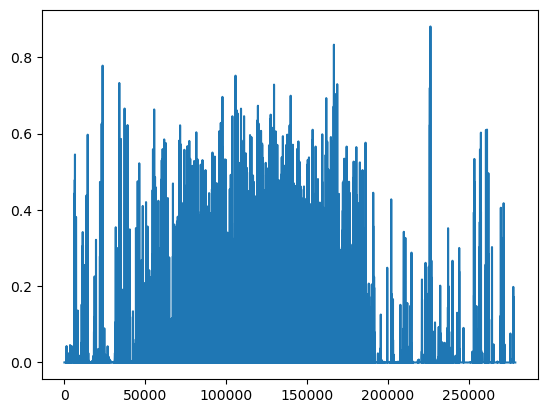

In [45]:
plt.plot(Y_pred)

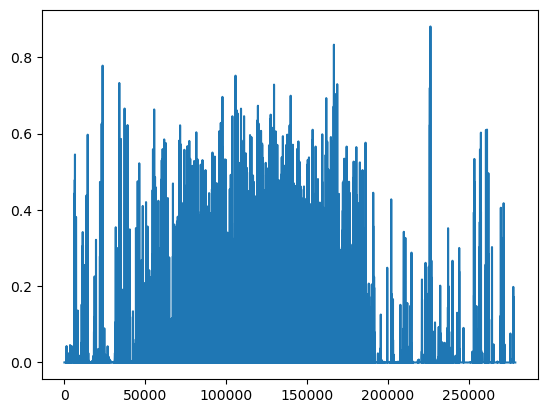

In [51]:
plt.plot(Y_pred)